In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using TensorFlow backend
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/config.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/tokenizer.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/metadata.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/model.weights.h5
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
Train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
Test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [3]:
Train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
Train_df[Train_df["target"] == 0]["text"].values[0]


"What's up man?"

In [5]:
Train_df[Train_df["target"] == 1]["text"].values[0]


'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [6]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(Train_df["text"][0:5])

## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


In [7]:
# Print the original tweets and their corresponding vector
for i in range(5):  # Assuming you're looking at the first five tweets
    print(f"Tweet {i+1}: {Train_df['text'][i]}")
    print(f"Vector: {example_train_vectors[i].todense()}")
    print("\n")


Tweet 1: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Vector: [[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


Tweet 2: Forest fire near La Ronge Sask. Canada
Vector: [[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]]


Tweet 3: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Vector: [[0 0 0 1 0 2 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 2 0 0 0 0 0 1 1 0 1 1 1 1 0 0
  0 2 0 0 0 1 0 0 0 0 0 2 0 0 0 1 0 0]]


Tweet 4: 13,000 people receive #wildfires evacuation orders in California 
Vector: [[1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]]


Tweet 5: Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
Vector: [[0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 1 1 0 0

In [8]:
Train_df["length"] = Train_df["text"].apply(lambda x : len(x))
Test_df["length"] = Test_df["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(Train_df["length"].describe())
print()

print("Test Length Stat")
print(Test_df["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [9]:

AUTO = tf.data.experimental.AUTOTUNE
X = Train_df["text"]
y = Train_df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = Test_df["text"]

In [10]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160, # the maximum no. of tokens
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2) # no. of classes 

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler



# Early Stopping and Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lambda epoch, lr: lr * 0.95 if epoch > 3 else lr)


optimizer=Adam(learning_rate=1e-5, weight_decay=1e-5)
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)

# Fit with data augmentation, early stopping, and learning rate scheduler
history = classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=32,  # Adjust batch size
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/10


I0000 00:00:1730940524.520940      67 service.cc:145] XLA service 0x7f70a40049b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730940524.520988      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730940567.153080      67 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_35', 120 bytes spill stores, 120 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'copy_fusion_2', 80 bytes spill stores, 80 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_xor_fusion_122', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1730940567.207616      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7450 - loss: 0.5549

I0000 00:00:1730940648.022215      65 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_48', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_31', 120 bytes spill stores, 120 bytes spill loads



191/191 ━━━━━━━━━━━━━━━━━━━━ 150s 467ms/step - accuracy: 0.7452 - loss: 0.5545 - val_accuracy: 0.8464 - val_loss: 0.3933 - learning_rate: 1.0000e-05
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.8436 - loss: 0.3733 - val_accuracy: 0.8464 - val_loss: 0.3875 - learning_rate: 1.0000e-05
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 46s 242ms/step - accuracy: 0.8781 - loss: 0.3204 - val_accuracy: 0.8365 - val_loss: 0.3971 - learning_rate: 1.0000e-05
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 46s 242ms/step - accuracy: 0.8951 - loss: 0.2723 - val_accuracy: 0.8293 - val_loss: 0.4366 - learning_rate: 1.0000e-05
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 46s 242ms/step - accuracy: 0.9200 - loss: 0.2323 - val_accuracy: 0.8267 - val_loss: 0.4819 - learning_rate: 9.5000e-06


In [12]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step


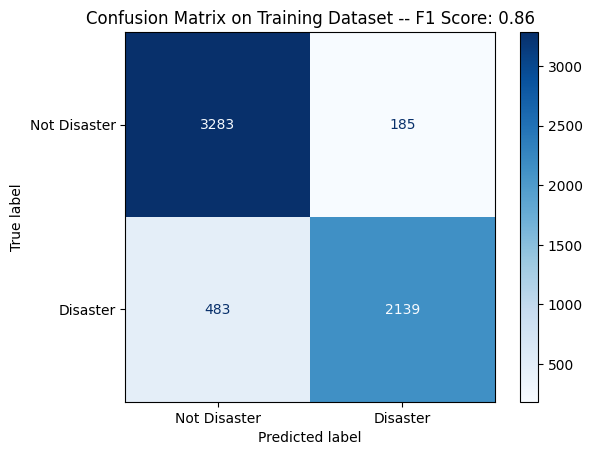

In [13]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step


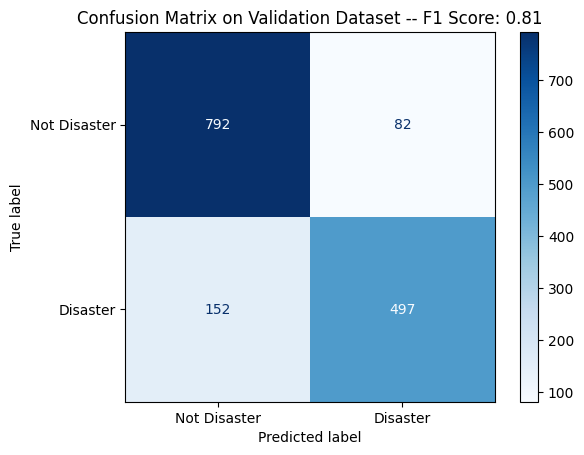

In [14]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [15]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [16]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step


In [17]:
sample_submission.to_csv("submission.csv", index=False)